In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# For saving model
import joblib


In [2]:
# Example: load CSV (replace with your file path)
data = pd.read_csv("Dataset.csv")

# Quick look
data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Basic info
data.info()

# Check for missing values
data.isnull().sum()

# Quick statistics
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
#No Use of Customer ID
#data = data.drop(columns = ["customerID"])
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

TotalCharges was stored as text due to blank values for new customers, so I explicitly coerced it to numeric and handled missing values separately.

In [5]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"].isna().sum()

11

In [6]:
# Checking tenure, MonthlyCharges for TotalCharges = 0 to cross check the assumption.

data.loc[data["TotalCharges"].isna(), ["tenure", "MonthlyCharges"]]

,tenure,MonthlyCharges
488,0,52.55
753,0,20.25
936,0,80.85
1082,0,25.75
1340,0,56.05
3331,0,19.85
3826,0,25.35
4380,0,20.00
5218,0,19.70
6670,0,73.35


Rule:
If tenure = 0 → customer has not completed any billing cycle
⇒ TotalCharges = 0

In [7]:
data.loc[data["tenure"] == 0, "TotalCharges"] = 0
data["TotalCharges"].isna().sum()

0

An outlier is NOT:
A customer paying a lot
A customer with long tenure

An outlier IS:
A value that is impossible, erroneous, or breaks business reality

# VISUALIZE NUMERIC FEATURES

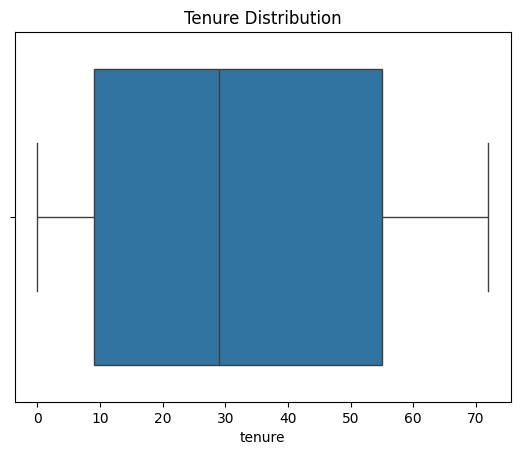

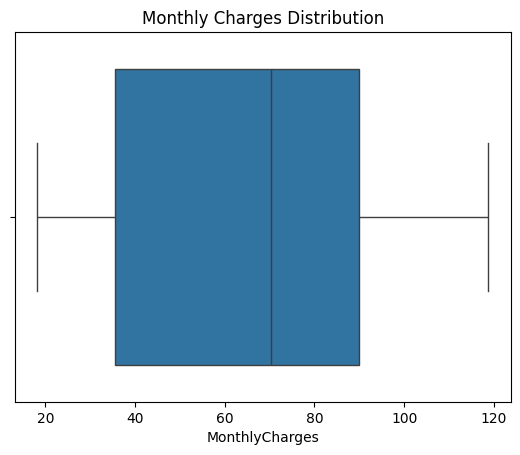

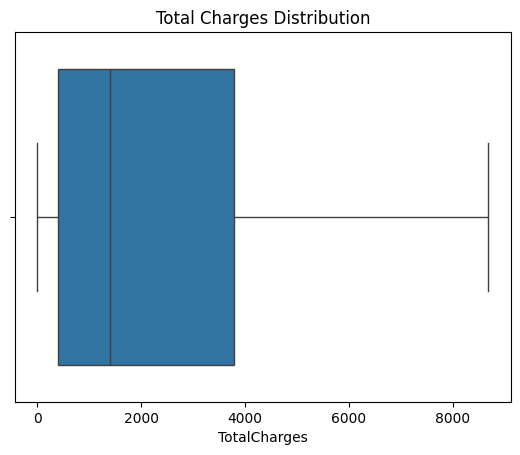

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=data["tenure"])
plt.title("Tenure Distribution")
plt.show()

sns.boxplot(x=data["MonthlyCharges"])
plt.title("Monthly Charges Distribution")
plt.show()

sns.boxplot(x=data["TotalCharges"])
plt.title("Total Charges Distribution")
plt.show()


CHECK NUMERIC LIMITS

In [9]:
data[["tenure", "MonthlyCharges", "TotalCharges"]].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


# There's No Outlier, So no need to handle Outliers.

# ENCODE Churn (EXPLICIT & SAFE)

In [10]:
data["Churn"] = data["Churn"].map({"No": 0, "Yes": 1})
data["Churn"].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

# Seperate Features and Targets

In [11]:
X = data.drop(columns=["Churn"])
X = X.drop(columns=["customerID"])
y = data["Churn"]
X.shape, y.shape

((7043, 19), (7043,))

# ENCODING + SCALING

In [12]:
numeric_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

categorical_features = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)


# BASELINE MODEL (LOGISTIC REGRESSION)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Train Baseline Logistic Regression (NO TUNING YET)

In [15]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear"
)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

Evaluating Model

In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.801277501774308
Precision: 0.6477987421383647
Recall: 0.5508021390374331
F1 Score: 0.5953757225433526
ROC AUC: 0.8412178046449146


Model catches only 55 out of 100 churn customers which is not sufficient for churn prediction


ROC-AUC measures:

How well the model ranks customers by churn risk

Recall depends on:

Threshold (default = 0.5)

✔️Model is ranking well
❌But decision threshold is conservative

# Overfitting and Underfitting Check

In [17]:
train_score = log_reg.score(X_train, y_train)
test_score = log_reg.score(X_test, y_test)

print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.806354277600284
Test Accuracy: 0.801277501774308


Hence No Overfitting or Underfitting as Train Accuracy ~= Test Accuracy

# THRESHOLD TUNING

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:,1]
thresholds = [0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    print(f"Threshold: {t}")
    print("Precision:", round(precision_score(y_test, y_pred_t),3))
    print("Recall   :", round(recall_score(y_test, y_pred_t),3))
    print("F1 Score :", round(f1_score(y_test, y_pred_t),3))
    print("-"*30)

Threshold: 0.3
Precision: 0.515
Recall   : 0.741
F1 Score : 0.607
------------------------------
Threshold: 0.4
Precision: 0.572
Recall   : 0.668
F1 Score : 0.617
------------------------------
Threshold: 0.5
Precision: 0.647
Recall   : 0.553
F1 Score : 0.597
------------------------------
Threshold: 0.6
Precision: 0.713
Recall   : 0.398
F1 Score : 0.511
------------------------------


C:\Users\manmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\manmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\manmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

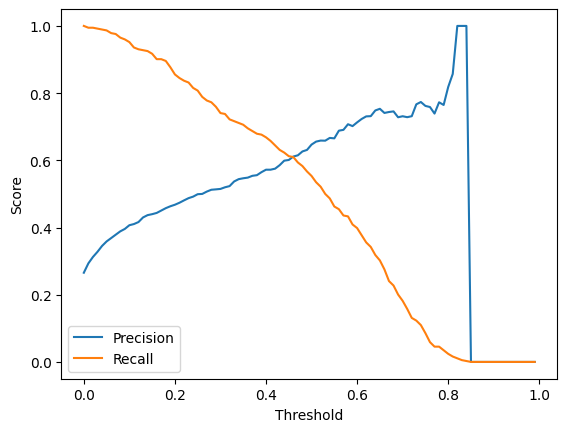

In [19]:
import matplotlib.pyplot as plt
import numpy as np

precisions, recalls, thresholds_plot = [], [], np.arange(0,1,0.01)
for t in thresholds_plot:
    y_pred_t = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))

plt.plot(thresholds_plot, precisions, label="Precision")
plt.plot(thresholds_plot, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


# Model With Threshhold = 0.4 so that more churners are caught

Confusion Matrix:
 [[848 187]
 [124 250]]

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.87      0.82      0.85      1035
       Churn       0.57      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



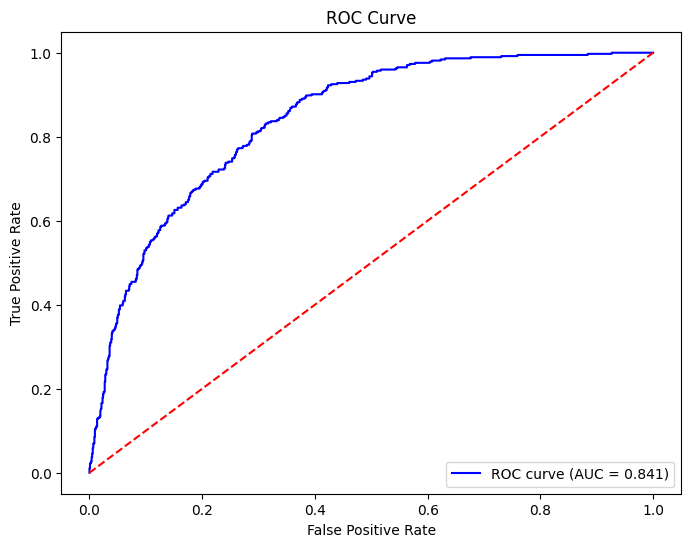

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
import matplotlib.pyplot as plt
import numpy as np
y_probs = logreg.predict_proba(X_test)[:, 1] 
threshold = 0.4
y_pred_threshold = (y_probs >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_threshold)
print("Confusion Matrix:\n", cm)
cr = classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"])
print("\nClassification Report:\n", cr)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# FEATURE IMPORTANCE FROM LOGISTIC REGRESSION

🎯Objective
Which features increase churn risk and which reduce it — and by how much?

In [21]:
num_features = numeric_features
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names = list(num_features) + list(cat_features)

In [22]:
import pandas as pd
import numpy as np

coefficients = logreg.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

coef_df.head(15)

,Feature,Coefficient,Abs_Coefficient
24,Contract_Two year,-1.333372,1.333372
0,tenure,-1.250601,1.250601
9,InternetService_Fiber optic,1.219735,1.219735
23,Contract_One year,-0.692523,0.692523
2,TotalCharges,0.524626,0.524626
6,PhoneService_Yes,-0.505924,0.505924
1,MonthlyCharges,-0.492685,0.492685
27,PaymentMethod_Electronic check,0.390149,0.390149
20,StreamingTV_Yes,0.384615,0.384615
22,StreamingMovies_Yes,0.384178,0.384178


In [23]:
coef_df["Impact"] = coef_df["Coefficient"].apply(
    lambda x: "Increases Churn" if x > 0 else "Decreases Churn"
)
coef_df.head(15)


,Feature,Coefficient,Abs_Coefficient,Impact
24,Contract_Two year,-1.333372,1.333372,Decreases Churn
0,tenure,-1.250601,1.250601,Decreases Churn
9,InternetService_Fiber optic,1.219735,1.219735,Increases Churn
23,Contract_One year,-0.692523,0.692523,Decreases Churn
2,TotalCharges,0.524626,0.524626,Increases Churn
6,PhoneService_Yes,-0.505924,0.505924,Decreases Churn
1,MonthlyCharges,-0.492685,0.492685,Decreases Churn
27,PaymentMethod_Electronic check,0.390149,0.390149,Increases Churn
20,StreamingTV_Yes,0.384615,0.384615,Increases Churn
22,StreamingMovies_Yes,0.384178,0.384178,Increases Churn


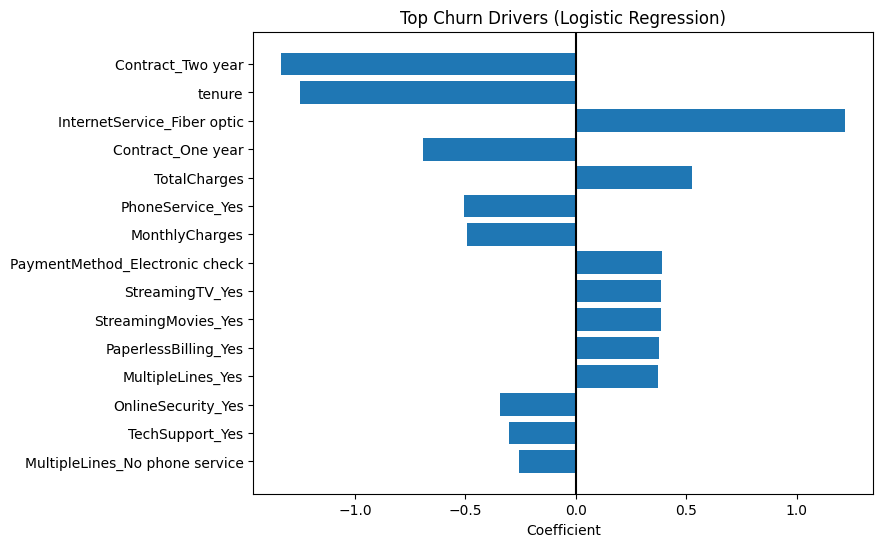

In [24]:
import matplotlib.pyplot as plt

top_features = coef_df.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Coefficient"])
plt.axvline(0, color="black")
plt.title("Top Churn Drivers (Logistic Regression)")
plt.xlabel("Coefficient")
plt.gca().invert_yaxis()
plt.show()


# STATISTICAL FEATURE SELECTION

ANNOVA FOR NUMERICAL FEATURES

In [25]:
numeric_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]
from sklearn.feature_selection import f_classif
import pandas as pd
X_num = data[numeric_features]
y_target = data["Churn"]  # already 0/1
f_scores, p_values = f_classif(X_num, y_target)

anova_df = pd.DataFrame({
    "Feature": numeric_features,
    "F_Score": f_scores,
    "P_Value": p_values
})

anova_df = anova_df.sort_values(by="F_Score", ascending=False)
anova_df


,Feature,F_Score,P_Value
0,tenure,997.268010,7.999058e-205
2,TotalCharges,288.278961,2.127212e-63
1,MonthlyCharges,273.463704,2.706646e-60


By Results, Every Numerical Feature is Important so have to keep it.

Chi - Square Test for Categorical Features

In [26]:
categorical_features = [
    "SeniorCitizen",
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
X_cat = data[categorical_features].copy()

le = LabelEncoder()
for col in categorical_features:
    X_cat[col] = le.fit_transform(X_cat[col])
chi_scores, p_vals = chi2(X_cat, y_target)

chi_df = pd.DataFrame({
    "Feature": categorical_features,
    "Chi2_Score": chi_scores,
    "P_Value": p_vals
})

chi_df = chi_df.sort_values(by="Chi2_Score", ascending=False)
chi_df


,Feature,Chi2_Score,P_Value
13,Contract,1115.780167,1.227941e-244
7,OnlineSecurity,551.611529,5.615882e-122
10,TechSupport,523.303866,8.086236e-116
8,OnlineBackup,230.086520,5.707869e-52
9,DeviceProtection,191.303140,1.651539e-43
0,SeniorCitizen,134.351545,4.576959e-31
3,Dependents,133.036443,8.876729e-31
14,PaperlessBilling,105.680863,8.661987e-25
2,Partner,82.412083,1.104764e-19
15,PaymentMethod,58.492250,2.040933e-14


Need to drop gender and PhoneService

Final Modelling Features set (16)

tenure, 
MonthlyCharges,
TotalCharges,
SeniorCitizen,
Partner,
Dependents,
MultipleLines,
InternetService,
OnlineSecurity,
OnlineBackup,
DeviceProtection,
TechSupport,
StreamingTV,
StreamingMovies,
Contract,
PaperlessBilling,
PaymentMethod,

# Feature Engineering - Adding new Features that will be of great importance for modelling

In [27]:
df = data.copy()
df["AvgMonthlySpend"] = df["TotalCharges"] / (df["tenure"] + 1)
def tenure_bucket(t):
    if t <= 6:
        return "New"
    elif t <= 24:
        return "Early"
    elif t <= 48:
        return "Mid"
    else:
        return "Loyal"

df["TenureBucket"] = df["tenure"].apply(tenure_bucket)
service_cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

df["ServiceCount"] = df[service_cols].apply(
    lambda x: sum(x == "Yes"), axis=1
)
df["IsMonthToMonth"] = (df["Contract"] == "Month-to-month").astype(int)
df[[
    "tenure", "TotalCharges", "AvgMonthlySpend",
    "ServiceCount", "IsMonthToMonth", "TenureBucket"
]].head()

,tenure,TotalCharges,AvgMonthlySpend,ServiceCount,IsMonthToMonth,TenureBucket
0,1,29.85,14.925000,1,1,New
1,34,1889.50,53.985714,2,0,Mid
2,2,108.15,36.050000,2,1,New
3,45,1840.75,40.016304,3,0,Mid
4,2,151.65,50.550000,0,1,New


In [28]:
df[[
    "tenure", "TotalCharges", "AvgMonthlySpend",
    "ServiceCount", "IsMonthToMonth", "TenureBucket"
]].describe()

,tenure,TotalCharges,AvgMonthlySpend,ServiceCount,IsMonthToMonth
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,2279.734304,58.990789,2.037910,0.550192
std,24.559481,2266.794470,30.579745,1.847682,0.497510
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,398.550000,26.041493,0.000000,0.000000
50%,29.000000,1394.550000,60.937879,2.000000,1.000000
75%,55.000000,3786.600000,84.830742,3.000000,1.000000
max,72.000000,8684.800000,118.969863,6.000000,1.000000


# REBUILD FULL PIPELINE (WITH ENGINEERED FEATURES)

In [29]:
y = df["Churn"]   # already encoded 0/1
drop_cols = [
    "customerID", 
    "gender",
    "PhoneService",
    "Contract"
]
X = df.drop(columns=drop_cols + ["Churn"])
numeric_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "AvgMonthlySpend",
    "ServiceCount"
]
binary_features = [
    "SeniorCitizen",
    "IsMonthToMonth"
]
categorical_features = [
    "Partner",
    "Dependents",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
    "PaymentMethod",
    "TenureBucket"
]
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"   # keeps binary features as-is
)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,                 # regularization strength
    solver="liblinear",
    max_iter=1000
)
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg)
    ]
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_prob))

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy :", model.score(X_test, y_test))



Accuracy: 0.8041163946061036
ROC AUC : 0.845118706244026
Train Accuracy: 0.811324103656372
Test Accuracy : 0.8041163946061036


In [30]:
# Get numeric feature names
num_features = numeric_features

# Get categorical feature names after one-hot encoding
cat_features = model.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(categorical_features)

# Binary features (passthrough)
bin_features = binary_features

# Combine all
all_features = list(num_features) + list(cat_features) + list(bin_features)

len(all_features)
model.named_steps["classifier"].coef_.shape[1]
import pandas as pd
import numpy as np

coef = model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coef,
    "AbsCoefficient": np.abs(coef)
})

coef_df = coef_df.sort_values(by="AbsCoefficient", ascending=False)
coef_df.head(15)

,Feature,Coefficient,AbsCoefficient
9,InternetService_Fiber optic,1.160266,1.160266
31,IsMonthToMonth,0.922532,0.922532
0,tenure,-0.913251,0.913251
4,ServiceCount,0.898687,0.898687
12,OnlineSecurity_Yes,-0.823594,0.823594
18,TechSupport_Yes,-0.792866,0.792866
14,OnlineBackup_Yes,-0.586662,0.586662
3,AvgMonthlySpend,-0.583400,0.583400
8,MultipleLines_Yes,0.418126,0.418126
16,DeviceProtection_Yes,-0.417584,0.417584


In [31]:
coef_df[coef_df["Coefficient"] > 0].head(10)

,Feature,Coefficient,AbsCoefficient
9,InternetService_Fiber optic,1.160266,1.160266
31,IsMonthToMonth,0.922532,0.922532
4,ServiceCount,0.898687,0.898687
8,MultipleLines_Yes,0.418126,0.418126
23,PaperlessBilling_Yes,0.374743,0.374743
25,PaymentMethod_Electronic check,0.347752,0.347752
29,TenureBucket_New,0.329345,0.329345
7,MultipleLines_No phone service,0.281293,0.281293
27,TenureBucket_Loyal,0.272055,0.272055
2,TotalCharges,0.264044,0.264044


# Insights 

🔴 CHURN RISK INSIGHTS (What increases churn)
1️⃣ Fiber Optic customers are the highest churn-risk segment

Evidence: InternetService_Fiber optic has the highest positive coefficient (+1.16)

Interpretation:
Fiber optic customers pay more and expect better service quality.

Business Insight:
Higher expectations + service issues = faster churn.

Action:
Proactively monitor service quality and offer loyalty benefits to fiber users.

2️⃣ Month-to-Month contracts strongly increase churn

Evidence: IsMonthToMonth (+0.92)

Interpretation:
Lack of commitment makes customers more likely to leave.

Business Insight:
Contract flexibility comes at the cost of retention.

Action:
Offer incentives to convert month-to-month users into annual contracts.

3️⃣ Customers with many services may churn if value is unclear

Evidence: ServiceCount (+0.89)

Interpretation:
More services ≠ more loyalty if customers feel overwhelmed or overcharged.

Business Insight:
Complexity without perceived value increases dissatisfaction.

Action:
Bundle services with discounts and clear value communication.

4️⃣ Electronic check payment users are riskier

Evidence: PaymentMethod_Electronic check (+0.35)

Interpretation:
Less automated, less sticky payment behavior.

Business Insight:
Customers not using auto-pay are easier to lose.

Action:
Encourage auto-pay or card payments with discounts.

5️⃣ New customers churn early

Evidence: TenureBucket_New (+0.33)

Interpretation:
Early-stage experience determines retention.

Business Insight:
Poor onboarding leads to quick churn.

Action:
Strengthen first 90-day onboarding programs.

6️⃣ Paperless billing is associated with higher churn

Evidence: PaperlessBilling_Yes (+0.37)

Interpretation:
Often correlated with digital-only, price-sensitive customers.

Business Insight:
Convenience alone does not ensure loyalty.

Action:
Combine digital billing with loyalty incentives.

🟢 RETENTION INSIGHTS (What reduces churn)
7️⃣ Tenure is the strongest retention factor

Evidence: tenure (−0.91)

Interpretation:
Customers who stay longer become increasingly loyal.

Business Insight:
Retention compounds over time.

Action:
Focus retention efforts on early tenure stages.

8️⃣ Security and support services strongly reduce churn

Evidence:

OnlineSecurity_Yes (−0.82)

TechSupport_Yes (−0.79)

Interpretation:
Customers feel safer and supported.

Business Insight:
Peace of mind is a powerful retention lever.

Action:
Bundle security and support with core plans.

9️⃣ Backup and device protection improve retention

Evidence:

OnlineBackup_Yes (−0.59)

DeviceProtection_Yes (−0.42)

Interpretation:
These services increase switching costs.

Business Insight:
Customers hesitate to churn when their data/devices are protected.

Action:
Promote protection add-ons to high-risk users.

🔟 Higher average spenders are more loyal when tenure is high

Evidence: AvgMonthlySpend (−0.58)

Interpretation:
Customers who pay more and stay longer perceive strong value.

Business Insight:
Price sensitivity decreases with perceived quality.

Action:
Retain high-value customers with personalized offers.

1️⃣1️⃣ Customers with dependents churn less

Evidence: Dependents_Yes (−0.23)

Interpretation:
Family customers prefer stability.

Business Insight:
Household dependence increases loyalty.

Action:
Family-oriented plans improve retention.

In [32]:
import joblib

# Suppose this is your trained pipeline
# model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', log_reg)])

# Save the model
joblib.dump(model, "churn_model.pkl")


['churn_model.pkl']